In [ ]:
# Mount Google Drive so the SPair-71k dataset can persist between sessions
from google.colab import drive
import os
drive.mount('/content/drive')

# Create a project folder to keep things organized
project_path = '/content/drive/MyDrive/AML_Project'

if not os.path.exists(project_path):
    os.makedirs(project_path)
    print(f"Created project directory at {project_path}")
else:
    print(f"Project directory already exists at {project_path}")

%cd {project_path}

Mounted at /content/drive
Project directory already exists at /content/drive/MyDrive/AML_Project
/content/drive/MyDrive/AML_Project


In [ ]:
import os
import shutil

# Force delete the broken repository folder
if os.path.exists('SD4Match'):
    shutil.rmtree('SD4Match')
    print("Cleaned up broken SD4Match directory.")

# Re-clone with depth=1
!git clone --depth 1 https://github.com/ActiveVisionLab/SD4Match.git

"""
SD4Match è una libreria di supporto che serve SOLO per caricare SPair-71k
e fornire immagini + keypoints già pronti per l’estrazione feature con DINOv3
(o altre backbone).
"""

# Verify the structure immediately
print("\nRepository Structure:")
for root, dirs, files in os.walk("SD4Match"):
    for file in files:
        if "spair" in file.lower():
             print(f"FOUND: {os.path.join(root, file)}")

Cleaned up broken SD4Match directory.
Cloning into 'SD4Match'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 48 (delta 6), reused 22 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 63.59 KiB | 957.00 KiB/s, done.
Resolving deltas: 100% (6/6), done.

Repository Structure:
FOUND: SD4Match/dataset/spair.py


In [ ]:
import os
import shutil

# Re-define the project path (just in case)
project_path = '/content/drive/MyDrive/AML_Project'

# Create a data directory to keep things clean
data_root = os.path.join(project_path, 'data')

# Remove existing data directory if it exists, then recreate it
if os.path.exists(data_root):
    print(f"Removing existing data directory at {data_root}...")
    shutil.rmtree(data_root)
    print("Data directory removed.")

os.makedirs(data_root, exist_ok=True)
print(f"Created empty data directory at {data_root}.")

%cd {data_root}

"""
SPair-71k è un grande dataset di 71.000 coppie di immagini con keypoints
corrispondenti, usato per testare e confrontare modelli che devono trovare
corrispondenze semantiche tra immagini.
"""

# Download SPair-71k (if not already present)
if not os.path.exists('SPair-71k'):
    print("Downloading dataset...")
    # Using wget to download from the official source
    !wget -q --show-progress http://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz

    print("Extracting...")
    # Extract the tar.gz file
    !tar -xzf SPair-71k.tar.gz

    # Cleanup to save space
    !rm SPair-71k.tar.gz
    print("Extraction complete.")
else:
    print("Dataset already exists.")

# Move back to project root
%cd {project_path}

Removing existing data directory at /content/drive/MyDrive/AML_Project/data...
Data directory removed.
Created empty data directory at /content/drive/MyDrive/AML_Project/data.
/content/drive/MyDrive/AML_Project/data
SPair-71k.tar.gz    100%[===================>] 216.45M  19.3MB/s    in 12s     
Extracting...
Extraction complete.
/content/drive/MyDrive/AML_Project


In [ ]:
import sys
import os
import importlib
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- SETUP PATHS ---
project_path = '/content/drive/MyDrive/AML_Project'
repo_path = os.path.join(project_path, 'SD4Match')
data_path = os.path.join(project_path, 'data', 'SPair-71k')

if repo_path not in sys.path:
    sys.path.append(repo_path)

# --- IMPORT DATASET CLASS ---
"""
Importa la classe SPairDataset che servirà per leggere SPair-71k
(immagini + keypoint).
"""
try:
    module = importlib.import_module("SD4Match.dataset.spair")
    SPairDataset = getattr(module, "SPairDataset")
    print(" Dataset class imported.")
except Exception as e:
    print(f"Import Error: {e}")



 Dataset class imported.


Loading dataset...
Reading SPair-71k information...


100%|██████████| 600/600 [00:01<00:00, 365.25it/s]


Successfully loaded 600 pairs.


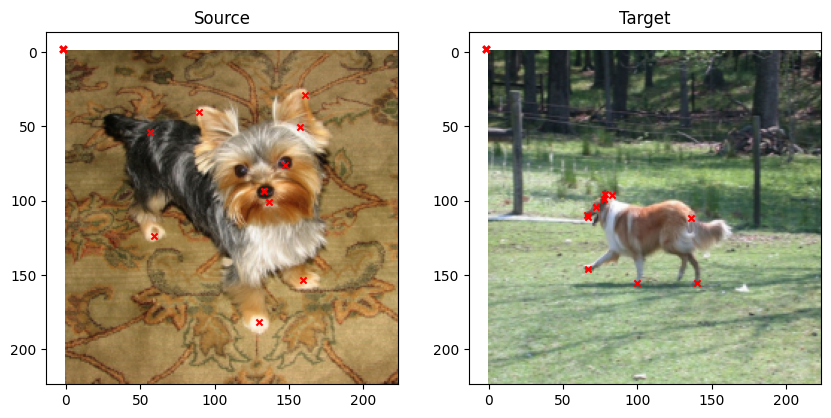


 First phase done.


In [ ]:
import sys
import os
import importlib
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- CREATE CONFIG ---
class Config:
    def __init__(self):
        class DatasetConfig:
            def __init__(self):
                self.ROOT = data_root
                self.NAME = 'spair'
                self.CATEGORY = 'cat'
                self.SIZE = 224
                self.IMG_SIZE = 224
                self.MEAN = [0.485, 0.456, 0.406]
                self.STD = [0.229, 0.224, 0.225]
        self.DATASET = DatasetConfig()

cfg = Config()

# --- LOAD & VISUALIZE ---
try:
    print(f"Loading dataset...")
    dataset = SPairDataset(cfg, 'test', 'dog')
    print(f"Successfully loaded {len(dataset)} pairs.")

    sample = dataset[0]

    src_img = sample['src_img']
    trg_img = sample['trg_img']
    src_kps = sample['src_kps'] # kps = key points
    trg_kps = sample['trg_kps']

    # Denormalize for visualization
    def denorm_show(img_tensor):
        img = img_tensor.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        return np.clip(img, 0, 1)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(denorm_show(src_img))
    ax[0].scatter(src_kps[:, 0], src_kps[:, 1], c='r', s=20, marker='x')
    ax[0].set_title(f"Source")

    ax[1].imshow(denorm_show(trg_img))
    ax[1].scatter(trg_kps[:, 0], trg_kps[:, 1], c='r', s=20, marker='x')
    ax[1].set_title(f"Target")
    plt.show()

    print("\n First phase done.")

except Exception as e:
    print(f"\n Error: {e}")

In [ ]:
# === clone_dinov3_repo ===
%cd /content/drive/MyDrive/AML_Project

# Remove previous clone if exists
import shutil, os
if os.path.exists("dinov3"):
    shutil.rmtree("dinov3")

# Clone the official DINOv3 repository
!git clone https://github.com/facebookresearch/dinov3.git

%cd dinov3
print("DINOv3 repository cloned successfully!")


/content/drive/MyDrive/AML_Project
Cloning into 'dinov3'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 538 (delta 199), reused 99 (delta 99), pack-reused 176 (from 1)
Receiving objects: 100% (538/538), 9.88 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (222/222), done.
Updating files: 100% (220/220), done.
/content/drive/MyDrive/AML_Project/dinov3
DINOv3 repository cloned successfully!


In [ ]:
# === download_dinov3_weights ===
# Carica i pesi DINOv3 dal tuo PC e li salva nella cartella del progetto

from google.colab import files
import os
import shutil

# Cartella dei pesi nel tuo progetto
weights_dir = "/content/drive/MyDrive/AML_Project/weights"
os.makedirs(weights_dir, exist_ok=True)

print("Seleziona dal tuo PC il file dei pesi DINOv3 (.pth)")
uploaded = files.upload()  # finestra per scegliere il file

# Prende il nome del file caricato
filename = list(uploaded.keys())[0]

# Sposta il file in Drive
dest_path = os.path.join(weights_dir, "dinov3_vitb16.pth")
shutil.move(filename, dest_path)

print(f"Pesi salvati in:\n{dest_path}")


Seleziona dal tuo PC il file dei pesi DINOv3 (.pth)


Saving dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth to dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
Pesi salvati in:
/content/drive/MyDrive/AML_Project/weights/dinov3_vitb16.pth


In [ ]:
# === setup_dinov3_model ===
import torch
import sys
import os

# Percorso dei pesi salvati precedentemente
weights_path = "/content/drive/MyDrive/AML_Project/weights/dinov3_vitb16.pth"

# Aggiungi la repo DINOv3 al path (se non già presente)
repo_path = "/content/drive/MyDrive/AML_Project/dinov3"
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Import del modello ViT-B/16 DINOv3
from dinov3.models.vision_transformer import vit_base

# Device (GPU se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Istanzia il modello ViT-B/16
model = vit_base(patch_size=16)

# Carica i pesi
print("Loading weights from:", weights_path)
ckpt = torch.load(weights_path, map_location="cpu")

# I pesi DINOv3 usano chiavi leggermente diverse: strict=False
missing, unexpected = model.load_state_dict(ckpt, strict=False)
print("Missing keys:", len(missing))
print("Unexpected keys:", len(unexpected))

# Manda il modello su GPU/CPU e in eval()
model.to(device)
model.eval()

print("\nDINOv3 ViT-B/16 is ready.")


Using device: cuda
Loading weights from: /content/drive/MyDrive/AML_Project/weights/dinov3_vitb16.pth
Missing keys: 0
Unexpected keys: 37

DINOv3 ViT-B/16 is ready.


In [ ]:
# === integrate_dinov3_with_spair ===
import torch
import torch.nn.functional as F

@torch.no_grad()
def extract_dino_features(img):
    """
    img : tensor (3,224,224) NORMALIZZATA come SPair-71k
    returns: (N_patch=196, dim=768)
    """
    x = img.unsqueeze(0).to(device)
    feat = model.forward_features(x)["x_norm_patchtokens"]
    return feat.squeeze(0).cpu()     # (196,768)


def keypoints_to_patch_ids(kps, H=224, W=224, patch=16):
    """
    kps: (num_keypoints, 2) -> (x,y)
    returns: patch ids (num_keypoints)
    """
    px = (kps[:,0] / patch).long()
    py = (kps[:,1] / patch).long()
    return py * (W//patch) + px      # id = row*14 + col


def match_keypoints(src_feats, trg_feats, src_patch_ids):
    """
    src_feats: (196,768)
    trg_feats: (196,768)
    src_patch_ids: (K)
    returns: matched_target_patch_ids (K)
    """
    # Normalize
    sf = F.normalize(src_feats, dim=1)       # (196,768)
    tf = F.normalize(trg_feats, dim=1)       # (196,768)

    # Cosine similarity matrix
    sim = sf @ tf.T                          # (196,196)

    # For each src keypoint patch → best target patch
    matched_ids = sim[src_patch_ids].argmax(dim=1)
    return matched_ids


###########################################################
# 1) Prendi un esempio dal dataset SPair-71k
###########################################################

sample = dataset[0]

src_img = sample["src_img"]   # (3,224,224)
trg_img = sample["trg_img"]
src_kps = sample["src_kps"]   # (K,2)
trg_kps = sample["trg_kps"]

print(f"Loaded one pair with {src_kps.shape[0]} keypoints.")

###########################################################
# 2) Estrai feature DINOv3 da entrambe le immagini
###########################################################

src_feats = extract_dino_features(src_img)    # (196,768)
trg_feats = extract_dino_features(trg_img)    # (196,768)

###########################################################
# 3) Converti keypoints → patch ID (0..195)
###########################################################

src_patch_ids = keypoints_to_patch_ids(src_kps)   # (K)

###########################################################
# 4) Esegui il matching con cosine similarity
###########################################################

matched_trg_patch_ids = match_keypoints(src_feats, trg_feats, src_patch_ids)

###########################################################
# 5) Convert patch IDs → coordinate immagine (x,y)
###########################################################

def patch_id_to_xy(pid, patch=16, grid=14):
    row = pid // grid
    col = pid %  grid
    return col*patch + patch//2, row*patch + patch//2

predicted_trg_kps = torch.tensor([patch_id_to_xy(pid) for pid in matched_trg_patch_ids])

print("\n=== RISULTATI ===")
print("Keypoints src:", src_kps.shape)
print("Patch IDs src:", src_patch_ids)
print("Matched trg patch IDs:", matched_trg_patch_ids)
print("Predicted target keypoints:", predicted_trg_kps)


Loaded one pair with 20 keypoints.

=== RISULTATI ===
Keypoints src: torch.Size([20, 2])
Patch IDs src: tensor([ 51,  33,  24,  65,  78,  92, 162, 135, 101,  45,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])
Matched trg patch IDs: tensor([187,  71, 153,  71,  91,  71,  87, 153, 153, 165,  54,  54,  54,  54,
         54,  54,  54,  54,  54,  54])
Predicted target keypoints: tensor([[ 88, 216],
        [ 24,  88],
        [216, 168],
        [ 24,  88],
        [120, 104],
        [ 24,  88],
        [ 56, 104],
        [216, 168],
        [216, 168],
        [184, 184],
        [200,  56],
        [200,  56],
        [200,  56],
        [200,  56],
        [200,  56],
        [200,  56],
        [200,  56],
        [200,  56],
        [200,  56],
        [200,  56]])
